# Multivariate Time Series
In this notebook, we show examples of how multivariate time series can be created and used in darts.

In [1]:
# fix python path if working locally
from utils import fix_pythonpath_if_working_locally
fix_pythonpath_if_working_locally()

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.models.tcn_model import TCNModel
from darts.dataprocessing.transformers import Scaler
from darts.metrics import r2_score
import darts.utils.timeseries_generation as tg

Let's start by creating two univariate TimeSeries instances and combining them to form a multivariate one using the TimeSeries.stack method.

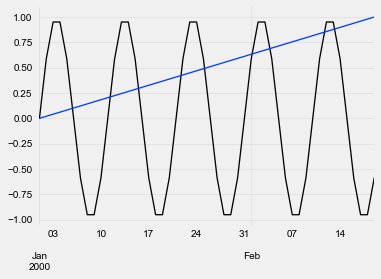

In [3]:
series_a = tg.sine_timeseries(length=50)
series_b = tg.linear_timeseries(length=50)
series_ab = series_a.stack(series_b)
series_ab.plot()

Any individual 'component' of a multivariate TimeSeries instance can be retrieved using the TimeSeries.univariate_component method which takes a 0-indexed integer as an argument.

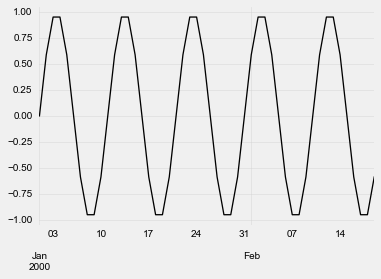

In [4]:
series_ab.univariate_component(0).plot()

In the following we will use real-world univariate data and see how we can expand upon it by creating multivariate TimeSeries objects.

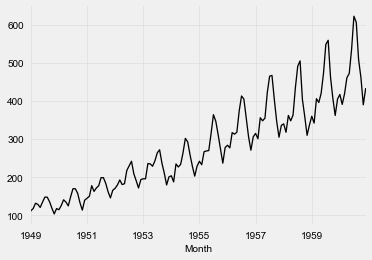

In [5]:
# Read data:
df = pd.read_csv('AirPassengers.csv', delimiter=",")
ts = TimeSeries.from_dataframe(df, 'Month', ['#Passengers'])
ts.plot()

Any univariate or multivariate TimeSeries instance can easily be augmented by additional components that are based on the datetime index. Any integer-valued attribute of pd.DatetimeIndex can be added, such as the number of the month, as shown below. Before plotting, the data is normalized so that all features are on the same scale.

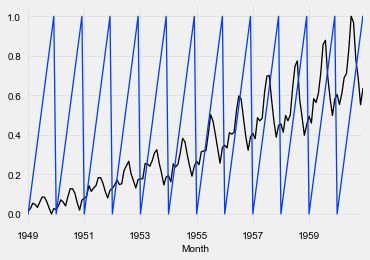

In [6]:
series_with_month = ts.add_datetime_attribute('month')
Scaler().fit_transform(series_with_month).plot()

Similarly, we can add a binary time series which indicates whether the current point on the time index represents a holiday in a specific country. Since the above time series is monthly, we shall use the artificial time series from before as an example.

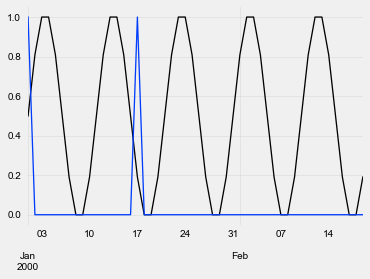

In [7]:
series_with_holidays = series_a.add_holidays('US')
Scaler().fit_transform(series_with_holidays).plot()

Now, how can we make use of such augmentations of TimeSeries instances? To see where it can help, let's look at the performance of a TCN forecasting model on the above air passengers data set. First let's fit the TCN model on the univariate series for 200 epochs and predict 13 steps into the future.

[2020-09-28 09:15:59,266] INFO | darts.models.tcn_model | Number of layers chosen: 2


Training loss: 0.0228, validation loss: 0.0610


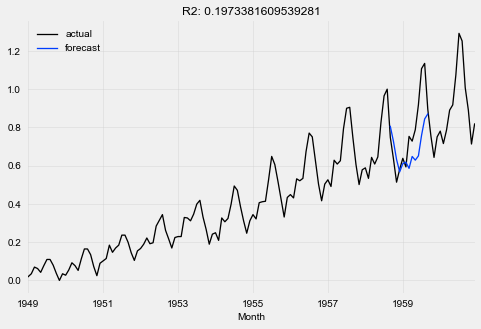

In [8]:
# Create training and validation sets:
train, val = ts.split_after(pd.Timestamp('19580801'))
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
ts_transformed = transformer.transform(ts)

# Create TCNModel instance
my_model = TCNModel(
    n_epochs=300,
    input_length=15,
    output_length=13,
    dropout=0.1,
    dilation_base=2,
    weight_norm=True,
    kernel_size=4,
    num_filters=3,
    random_state=0
)

# Fit model
my_model.fit(train_transformed, val_training_series=val_transformed, verbose=True)

# Evaluate model
def eval_model(model):
    pred_series = model.predict(13, True)
    plt.figure(figsize=(8,5))
    ts_transformed.univariate_component(0).plot(label='actual')
    pred_series.plot(label='forecast')
    plt.title('R2: {}'.format(r2_score(val_transformed.univariate_component(0), pred_series.slice_intersect(val_transformed))))
    plt.legend();
eval_model(my_model)

Limited to 20 epochs, we do not get a very good performance. Let's try the same thing but with an enhanced series that contains information about the month. Here, we also pass the second positional argument to the 'add_datetime_attribute' method which refers to whether the datetime attribute should be encoded in a one-hot fashion or not. Note that for predictions of multivariate TimeSeries instances, the maximum number of steps that can be predicted into the future is equal to TorchForecastingModel.output_length.

[2020-09-28 09:16:05,973] INFO | darts.models.tcn_model | Number of layers chosen: 2


Training loss: 0.0159, validation loss: 0.0428


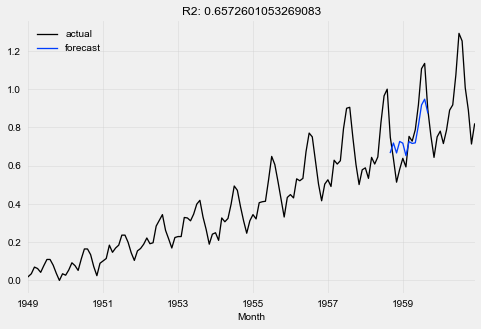

In [9]:
# Create training and validation sets:
ts_enhanced = ts.add_datetime_attribute('month', True)
train, val = ts_enhanced.split_after(pd.Timestamp('19580801'))
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
ts_transformed = transformer.transform(ts_enhanced)

# Create TCNModel instance
my_model = TCNModel(
    input_size=13,
    n_epochs=300,
    input_length=15,
    output_length=13,
    dropout=0.1,
    dilation_base=2,
    weight_norm=True,
    kernel_size=4,
    num_filters=3,
    random_state=0
)

# Fit model
my_model.fit(
    target_series=train_transformed['0'],
    training_series=train_transformed,
    val_target_series=val_transformed['0'],
    val_training_series=val_transformed,
    verbose=True
)

#Evaluate model
eval_model(my_model)

We can see that with this limited number of training epochs, we get a better performance out of the model that uses the multivariate series as input.